Copyright © 2024 Gurobi Optimization, LLC

# Price Optimization with Competing Products
Finding the delicate balance between price and demand is a difficult problem to solve and one that is prevalent in a number of huge industries like retail, e-commerce, ticketing, and hospitality.

It just so happens that this is a problem that data scientists have recently been getting better and better at addressing. Still, a key piece is missing: How can I make the right pricing decision given all the other constraints and business rules that exist for this problem? That's where optimization comes in.

In this scenario, we have a product that has several categories, but we have a limited amount of "space" for our products. This could be shelf or warehouse space in retail, seats for events, or for airline ticketing, or rooms at a hotel.

This problem considers two similar products that are offered where it's our job to use the data available with some optimization know-how to determine the optimal mix of products to offer that maximize revenue while also adhering to a few other business rules. First, we'll create a predictive model to forecast sales based on the prices of each product. Then we'll build an optimization model to find this optimal mix. Finally, we’ll also use the Gurobi-sponsored open-source package Gurobi Machine Learning to seamlessly combine the features of a machine learning model with a decision of an optimization model.

Let’s get started!

## Load required packages
If you have a Gurobi license you can skip the installation of `gurobipy`, but always make sure you have the [latest version](https://www.gurobi.com/downloads/gurobi-software) available.

In [1]:
%pip install gurobipy

In [2]:
import gurobipy as gp
from gurobipy import GRB

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn import tree

warnings.filterwarnings("ignore")

## Start with some data analysis

This data contains prices and sales for two of our competing products and was generated using another script, which can be found [here](). Let's load the data and take a quick look.

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/pricing_competing_products/price_value_data.csv')
df

,p[1],p[2],n[1]
0,356.12,197.67,108.0
1,358.05,189.68,66.0
2,340.79,260.35,130.0
3,353.76,133.53,55.0
4,341.37,229.80,91.0
...,...,...,...
995,357.63,241.54,68.0
996,352.58,212.95,87.0
997,355.28,189.50,94.0
998,369.75,166.33,51.0


### What's in the data?
The data contains three columns:
1. `p[1]` is the price (in dollars) of the first category (let's call it Category 1).
2. `p[2]` is the price (in dollars) of the second category (Category 2).
3. `n[1]` is the number of the items sold that are of Category 1.

We don't see a column for `n[2]`, which would be the number of items sold that are Category 2. Here is where we make a **pretty big assumption** that we will sell all of the items. This makes our decision to be how to divvy up the limited space we have in order to maximize our revenue.
The data was created to have a couple of key characteristics.
1. As the price of Category 1 goes up, the number sold should decrease, so `p[1]` and `n[1]` have a negative correlation.
2. As the price of Category 2 goes up, the number sold of Category 1 should increase, so `p[2]` and `n[1]` have a positive correlation.

The correlation plot of the columns of the data is below.

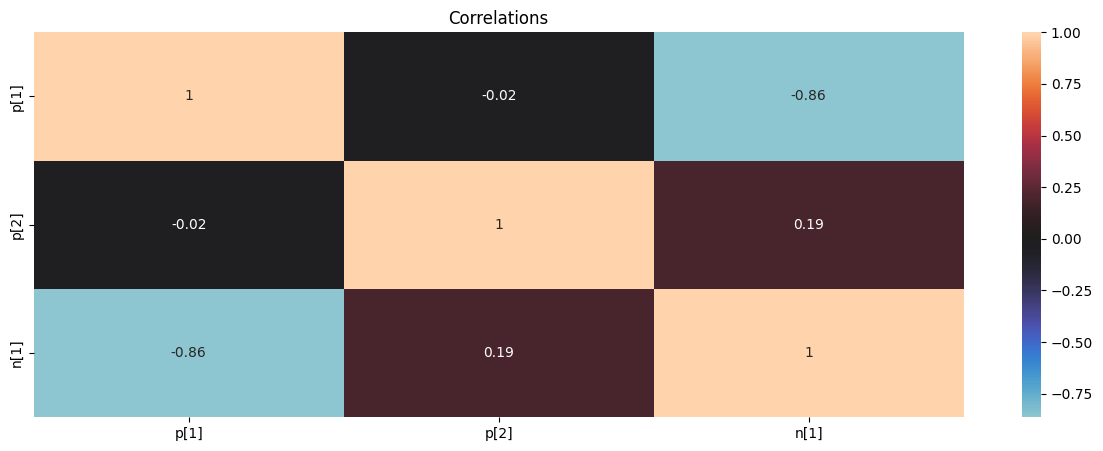

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
sns.heatmap(df[['p[1]','p[2]','n[1]']].corr(),annot=True, center=0,ax=axes)

axes.set_title('Correlations')
plt.show()

In this problem, we've assumed that the amount of space we have available for the products is 200 units. In retail, this could be the amount of warehouse space, or for ticketing this could represent the number of seats available.

### Building regressors to predict sales

The prices for each category item will be used to predict the number of Category 1 items sold. Here we build a regression model to form this relationship which will later be used as part of the optimization model.

In [5]:
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split      #importing scikit-learn's function for data splitting
from sklearn.ensemble import GradientBoostingRegressor    #importing scikit-learn's gradient booster regressor function
from sklearn.model_selection import cross_validate        #improting scikit-learn's cross validation function

In [6]:
X = df[["p[1]","p[2]"]]
y = df["n[1]"]
# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, random_state=1
)

First we'll start with a linear regression model.

In [7]:
linear_regressor = make_pipeline(LinearRegression())
linear_regressor.fit(X_train, y_train)
linear_regression_validation = cross_validate(linear_regressor, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

linear_regression_validation['train_score'],linear_regression_validation['test_score']

(array([0.80665368, 0.81004987, 0.7941077 , 0.79780172, 0.79495142]),
 array([0.77650521, 0.74227784, 0.82105606, 0.81102818, 0.82166193]))

Let's try a gradient boosting model as well.

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
xgb_regressor = make_pipeline(GradientBoostingRegressor(n_estimators=10))
xgb_regressor.fit(X_train, y_train)
xgb_regressor_validation = cross_validate(xgb_regressor, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

xgb_regressor_validation['train_score'], xgb_regressor_validation['test_score']


(array([0.71068886, 0.71262322, 0.70264476, 0.70564959, 0.7008412 ]),
 array([0.65706085, 0.69348053, 0.66690978, 0.67664668, 0.67992755]))

## Price optimization model with competing products

Our problem is to:
1.	Determine the number of each category of product to make available given the overall restriction of what we can offer.
2.	We are also instructed to make sure there are a minimum number of each category made available as well as a minimum and maximum price for each category.
3.	Lastly, the product categories should be decreasing in price, meaning Category 1 should be the most expensive, and so on. Specifically, we must make sure there is at least a $50 gap between categories, but no more than $100.

With the predictive part in place, it's time to build the optimization model. The model is formulated (i.e. the mathematical representation) for an unspecified number of categories, but the code will reflect that we have two categories of products in this problem. We start by setting some parameter values (not to be confused with ML hyperparameters) and initialize the optimization model.



### Initialize model and set input parameters
- $C$: Number of product categories
- $N$: Total amount of space available
- $\lambda$: Price control parameter

Here is the first mention of a price control parameter. It is fairly common in optimization modeling to add penalty terms to try and prevent undesirable outcomes. This is akin to using penalty terms in machine learning and applied statistics to prevent overfitting, with [Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics)) and [Ridge](https://en.wikipedia.org/wiki/Ridge_regression) regression as a couple of common examples.

In [9]:
#### Initialize the model
m = gp.Model("price optimization")

products = [1,2]            #### Category 1 and Category 2
N = 200                     #### limit on available space
l = 0                       #### price control, we'll start this at 0

Restricted license - for non-production use only - expires 2025-11-24


### Decision variables
- $p_c$: price per item in category $c = 1,2,\dots, C$
- $n_c$: number of items allocated to category, predicted using features $p_c$, $c = 1,2,\dots, C$

In [10]:
p = m.addVars(products, name="p")            #### price decision variables
n = m.addVars(products, name="n")            #### decision variable for number of items in each category

### Constraints

We need to have a minimum number of each category available.
\begin{align*}
n_c \ge l_{n_c}
\end{align*}

We also set lower and upper bounds on the prices.
\begin{align*}
l_{n_c} \le p_c \le u_{p_c}
\end{align*}

In [11]:
min_items = {1:50,2:50}
price_bounds = {1:[300,400], 2:[100,300]}
m.addConstrs(n[c] >= min_items[c] for c in products)        #### we could hardcode 50 instead of min_items, but this is more flexible
m.addConstr(p[1] == [300,400])                              #### this is a shorthand way to code 300 <= p[1] <= 400
m.addConstr(p[2] == [100,300]);

Another note: each of the above constraints can be addressed when defining the decision variables. Here is an example for the decision variable $n$.

In [12]:
#price_lb = {1:300, 2:100}
#price_ub = {1:400, 2:300}
#p = m.addVars(products, lb = price_lb, ub = price_ub, name="p")     #### each price is now bounded
#n = m.addVars(products, lb = min_items, name="n")

In general, the number of items allocated must equal the total available space.
\begin{equation*}
n_1 + n_2 + \dots + n_C = \sum_{c}n_c = N \\
\end{equation*}
Note that this, along with the constraint on the minimum number available means we don't have to specify an upper bound for each $n_c$.

In [13]:
m.addConstr(n.sum() ==  N);     #### remember we set N = 200 earlier

The last set of constraints are for price ordering. This requires the subsequent category to be cost between $50 and $100 less than the previous.
\begin{equation*}
50 \le p_c - p_{c+1} \le 100
\end{equation*}

In [14]:
m.addConstr(p[1]-p[2] == [50,100]);

### Objective function

We want to maximize total revenue with the portion of total revenue coming from category $c$ being $p_cn_c$. This makes the total revenue $\sum_{c} p_c n_c$. That is the first part of the objective. Earlier a price control parameter was introduced which is the second part of the objective. The lambda parameter captures the trade-off between the revenue and price-control pieces. This term penalizes the model from setting too high of prices since doing so could lose sales. Our model assumed we'll sell all of the items so having this penalty term can make this assumption more realistic. For reference, [here is a good source](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4565407).

This term will be defined as $λ (\sum_{c} p_c^2)$ for this problem. So, the complete objective is:
\begin{equation*}
\textrm{maximize} \sum_{c} p_c n_c - λ (\sum_{c} p_c^2)
\end{equation*}

In [15]:
revenue = gp.quicksum(p[c]*n[c] for c in products)          #### you could also use the more simple p.prod(n)
penalty = l*(p[1]**2+p[2]**2)                               #### we used l as the lambda parameter earlier
m.setObjective(revenue - penalty, sense = GRB.MAXIMIZE)

### Integrate the ML model


Right now, if we were to run the optimization, the solution would be to set the price for Category 1 to $400, Category 2 to $300, and sell 150 and 50 of each item, respectively. That's because we have yet to add in the relationship between price and demand that was derived from the ML model. To integrate the machine learning model into the optimization model, we'll use the Gurobi Machine Learning package. The magic happens using `add_predictor_constr` function.

In [16]:
#### install the package and load the required function
%pip install gurobi-machinelearning
from gurobi_ml import add_predictor_constr

This additional package is useful when we have **decision variables** that are also **features** of a machine learning model. First, we need a data frame that contains these decision variables. It is important to make sure the indices of the data frame have the **same name** as the training data for the machine learning model.

In [17]:
m_feats = pd.DataFrame({"p[1]":[p[1]],"p[2]":[p[2]]})

Adding the predictive model to the optimization model requires specifying the model we want to use `(m)`, regression object `(xgb_regressor)`, feature data frame `(m_feats)`, and the output decision variable `(n[1])`. Remember `n[2]` is **NOT** the output of the regression. We can then print the number of variables and constraints added to the model using `print_stats`.


In [18]:
pred_constr = add_predictor_constr(m, xgb_regressor, m_feats, n[1])
pred_constr.print_stats()

Model for pipe:
90 variables
11 constraints
246 general constraints
Input has shape (1, 2)
Output has shape (1, 1)

Pipeline has 1 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
gbtree_reg            (1, 1)           90           11            0          246

--------------------------------------------------------------------------------


### Solve the optimization and get the solution

Since this is a quadratic, non-convex problem we set the `NonConvex` parameter to 2. See the [documentation](https://www.gurobi.com/documentation/current/refman/nonconvex.html) for more information. We'll also print out the optimal solution.

In [19]:
m.Params.NonConvex = 2
m.optimize()

Set parameter NonConvex to value 2
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 17 rows, 97 columns and 102 nonzeros
Model fingerprint: 0x2255329b
Model has 2 quadratic objective terms
Model has 246 general constraints
Variable types: 17 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 2e+02]
  RHS range        [1e+00, 4e+02]
  GenCon rhs range [3e-01, 4e+02]
  GenCon coe range [1e+00, 1e+00]
Presolve added 44 rows and 0 columns
Presolve removed 0 rows and 15 columns
Presolve time: 0.10s
Presolved: 66 rows, 85 columns, 383 nonzeros
Presolved model has 2 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 18 continuous, 67 integ

In [20]:
print("\nOptimal price for the two categories:\n",round(p[1].X,2),round(p[2].X,2))
print("\nOptimal number of space assigned to the two categories:\n",round(n[1].X), round(n[2].X))
print("\nTotal revenue:\n",round(revenue.getValue(),2))


Optimal price for the two categories:
 364.97 300.0

Optimal number of space assigned to the two categories:
 91 109

Total revenue:
 65931.83


## Follow-up questions
At this point the λ value is set to zero, meaning we are not penalizing the price. One way to see the sensitivity of the prices and number of items set to each category is solving the model for multiple values of λ. This can be done fairly easy in `gurobipy`. Check out the documentation for how Gurobi can handle [multiple scenarios]('https://www.gurobi.com/documentation/current/refman/multiple_scenarios.html').

We also only used the trained `xgb_regressor` for the optimization to show the number of variables and constraints added to the model. Test the `linear_regressor` that was trained as well. You can do that by re-running the cells or by adding to the code to [remove the previous predictor constraints](https://gurobi-machinelearning.readthedocs.io/en/stable/auto_generated/gurobi_ml.sklearn.linear_regression.LinearRegressionConstr.html#gurobi_ml.sklearn.linear_regression.LinearRegressionConstr.remove) and adding new ones.

Copyright © 2024 Gurobi Optimization, LLC